In [8]:
import os
from src.utils import data_load
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from utils import get_survey_question, na_rate
import torch
import matplotlib.dates as mdates
import pingouin as pg

In [9]:
import pingouin as pg

In [10]:
# wave = 7
# bucket = 'fouryouandme-study-data'
# dfs = {}
# key = f'bump/redcap/wave_{wave}/pitting_edema.csv.gz'
# df_pitting_edema_cohort_2_only = pandas_from_csv_s3(bucket, key=key, compression='gzip')
# dfs['pitting_edema'] = df_pitting_edema_cohort_2_only
df_survey = data_load(data_keys={"surveys"}, wave=7)['surveys']
data = data_load(data_keys={'pitting_edema'}, wave=7)['pitting_edema']
# df_birth = data_load(data_keys={"birth"}, wave=5)['birth']

/storage/home/ruizhu/Rui-s_BUMP_code_dump/src/s3_utils.py:68: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, compression=compression)


In [11]:
df_sleep = data_load(data_keys={"oura_sleep"}, wave=5)['oura_sleep']

In [12]:
df_sleep.columns

Index(['id', 'user_id', 'identity_id', 'created_at', 'updated_at',
       'retrieved_at', 'subsource', 'event_date', 'awake', 'bedtime_end',
       'bedtime_end_delta', 'bedtime_start', 'bedtime_start_delta',
       'breath_average', 'deep', 'duration', 'efficiency', 'hr_5min',
       'hr_average', 'hr_lowest', 'hypnogram_5min', 'is_longest', 'light',
       'midpoint_at_delta', 'midpoint_time', 'onset_latency', 'period_id',
       'rem', 'restless', 'rmssd', 'rmssd_5min', 'score', 'score_alignment',
       'score_deep', 'score_disturbances', 'score_efficiency', 'score_latency',
       'score_rem', 'score_total', 'temperature_delta',
       'temperature_deviation', 'temperature_trend_deviation', 'timezone',
       'total', 'record_id', 'date'],
      dtype='object')

In [13]:
identifier = 'record_id'
dataset_dir_name = 'dataset_LT'

In [14]:

all_data = None

for u in data[identifier].unique():
    edema_csv_path = f'../{dataset_dir_name}/edema/user_{u}_edema_label.csv'
    if not os.path.exists(edema_csv_path):
        #print("Empty Edema")
        continue
    edema_df = pd.read_csv(edema_csv_path).groupby("date", as_index = False).first()[['date', 'edema']]
    pitting_edema_df = data[data[identifier] == u][['date', 'pitting_edema']]
    combined = pd.merge(edema_df, pitting_edema_df, how='left')
    # combine daily edema and pitting edema, only keeping those with pitting edema available
    combined_right = pd.merge(edema_df, pitting_edema_df, how='right')
    combined_right = combined_right.dropna()
    def add_username(date, username):
        return str(date) + '_' + username

    if len(combined_right):
        # Apply the custom function to modify the column
        combined_right['date_username'] = combined_right.apply(lambda row: add_username(row['date'], str(u)), axis=1)
        combined_right[identifier] = str(u)
        # combined_right = combined_right.drop('date', axis=1)
        # print(combined_right)
        if all_data is None:
            all_data = combined_right
        else:
            all_data = pd.concat([all_data, combined_right], ignore_index=True)
            # all_data.append(combined_right, ignore_index=True)
    # if combined['pitting_edema'].count():
    # # Reshape the DataFrame using melt()
    #     melted_df = combined.melt(id_vars='date', var_name='y_label', value_name='y_value')

    #     # Plot the values using sns.lineplot()
    #     ax = sns.stripplot(data=melted_df, x='date', y='y_value', hue='y_label')
    #     ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    #     ax.figure.savefig((os.path.join('/', 'mnt', 'results', 'pitting_edema', f'{u}.png')))       
        
    #     ax.figure.clf()
print(all_data)
melted_df = all_data.drop('date', axis=1).drop(identifier, axis=1).melt(id_vars='date_username', var_name='y_label', value_name='y_value')
icc = pg.intraclass_corr(data=melted_df, targets='date_username', raters='y_label', ratings='y_value')

icc.set_index('Type')
icc

            date  edema  pitting_edema          date_username   record_id
0     2021-04-29    1.0            0.0     2021-04-29_sema4_4     sema4_4
1     2021-05-27    1.0            0.0     2021-05-27_sema4_4     sema4_4
2     2021-07-22    1.0            0.0     2021-07-22_sema4_4     sema4_4
3     2021-04-06    1.0            0.0     2021-04-06_sema4_5     sema4_5
4     2021-06-03    1.0            0.0     2021-06-03_sema4_5     sema4_5
...          ...    ...            ...                    ...         ...
1063  2022-11-17    1.0            0.0  2022-11-17_direct_536  direct_536
1064  2023-01-19    1.0            0.0  2023-01-19_direct_536  direct_536
1065  2023-02-09    1.0            0.0  2023-02-09_direct_536  direct_536
1066  2023-03-07    2.0            0.0  2023-03-07_direct_617  direct_617
1067  2023-04-04    2.0            0.0  2023-04-04_direct_617  direct_617

[1068 rows x 5 columns]


,Type,Description,ICC,F,df1,df2,pval,CI95%
0,ICC1,Single raters absolute,-0.330015,0.503742,883,884,1.000000e+00,"[-0.39, -0.27]"
1,ICC2,Single random raters,0.097431,1.750046,883,883,7.324829e-17,"[-0.06, 0.27]"
2,ICC3,Single fixed raters,0.272739,1.750046,883,883,7.324829e-17,"[0.21, 0.33]"
3,ICC1k,Average raters absolute,-0.985143,0.503742,883,884,1.000000e+00,"[-1.27, -0.74]"
4,ICC2k,Average random raters,0.177562,1.750046,883,883,7.324829e-17,"[-0.13, 0.42]"
5,ICC3k,Average fixed raters,0.428586,1.750046,883,883,7.324829e-17,"[0.35, 0.5]"


In [15]:
all_data

,date,edema,pitting_edema,date_username,record_id
0,2021-04-29,1.0,0.0,2021-04-29_sema4_4,sema4_4
1,2021-05-27,1.0,0.0,2021-05-27_sema4_4,sema4_4
2,2021-07-22,1.0,0.0,2021-07-22_sema4_4,sema4_4
3,2021-04-06,1.0,0.0,2021-04-06_sema4_5,sema4_5
4,2021-06-03,1.0,0.0,2021-06-03_sema4_5,sema4_5
...,...,...,...,...,...
1063,2022-11-17,1.0,0.0,2022-11-17_direct_536,direct_536
1064,2023-01-19,1.0,0.0,2023-01-19_direct_536,direct_536
1065,2023-02-09,1.0,0.0,2023-02-09_direct_536,direct_536
1066,2023-03-07,2.0,0.0,2023-03-07_direct_617,direct_617


[0. 1. 2. 5. 3. 4. 6.]


<Axes: xlabel='edema', ylabel='pitting_edema'>

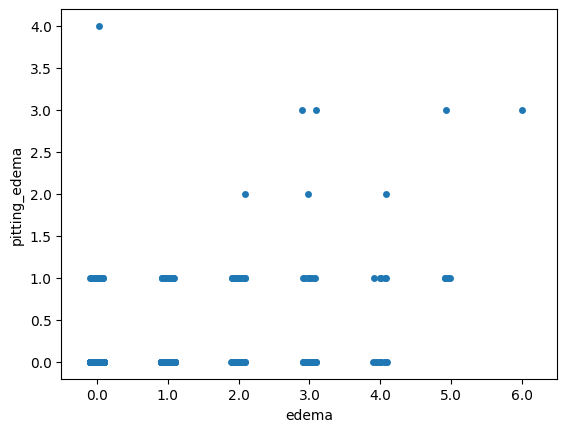

In [16]:
all_data.edema = all_data.edema - 1
print(all_data.edema.unique())
sns.stripplot(data=all_data, x='edema', y='pitting_edema')

In [17]:
all_data.edema.unique

<bound method Series.unique of 0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
1063    0.0
1064    0.0
1065    0.0
1066    1.0
1067    1.0
Name: edema, Length: 1068, dtype: float64>

In [18]:

severe_daily_no_pitting = (all_data['edema'] >=2.0) & (all_data['pitting_edema'] == 0.0)
no_daily_severe_pitting = (all_data['edema'] == 0.0) & (all_data['pitting_edema'] > 0.0)

unreliable_users = all_data[(severe_daily_no_pitting | no_daily_severe_pitting)][identifier].unique()

reliable_data = all_data[~all_data[identifier].isin(unreliable_users)]

<Axes: xlabel='edema', ylabel='pitting_edema'>

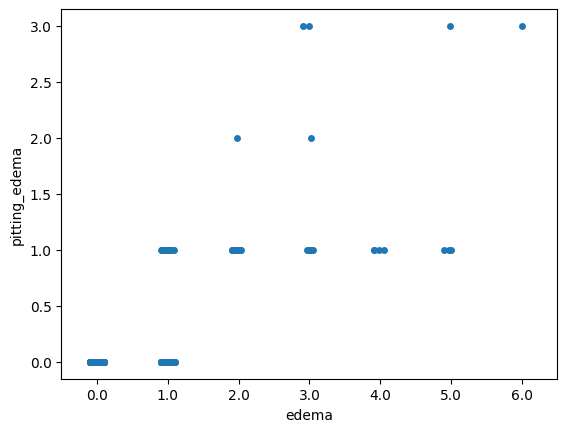

In [19]:
sns.stripplot(data=reliable_data, x='edema', y='pitting_edema')

In [20]:
melted_df = reliable_data.drop('date', axis=1).drop(identifier, axis=1).melt(id_vars='date_username', var_name='y_label', value_name='y_value')
icc = pg.intraclass_corr(data=melted_df, targets='date_username', raters='y_label', ratings='y_value')

icc.set_index('Type')
icc

,Type,Description,ICC,F,df1,df2,pval,CI95%
0,ICC1,Single raters absolute,0.584674,3.815496,664,665,1.102883e-62,"[0.53, 0.63]"
1,ICC2,Single random raters,0.593148,4.240811,664,664,8.198199e-72,"[0.5, 0.67]"
2,ICC3,Single fixed raters,0.618380,4.240811,664,664,8.198199e-72,"[0.57, 0.66]"
3,ICC1k,Average raters absolute,0.737911,3.815496,664,665,1.102883e-62,"[0.69, 0.77]"
4,ICC2k,Average random raters,0.744624,4.240811,664,664,8.198199e-72,"[0.67, 0.8]"
5,ICC3k,Average fixed raters,0.764196,4.240811,664,664,8.198199e-72,"[0.73, 0.8]"


In [21]:
print(list(reliable_data[identifier].unique()))

['sema4_4', 'sema4_5', 'sema4_6', 'sema4_11', 'sema4_13', 'sema4_14', 'sema4_15', 'sema4_18', 'sema4_19', 'sema4_20', 'sema4_22', 'sema4_24', 'sema4_25', 'sema4_34', 'sema4_36', 'sema4_37', 'sema4_38', 'sema4_39', 'sema4_44', 'sema4_45', 'sema4_49', 'sema4_50', 'sema4_64', 'sema4_65', 'sema4_66', 'sema4_69', 'sema4_70', 'sema4_80', 'sema4_82', 'sema4_85', 'sema4_86', 'sema4_87', 'sema4_89', 'sema4_92', 'sema4_93', 'sema4_95', 'sema4_97', 'sema4_112', 'sema4_113', 'sema4_116', 'sema4_118', 'sema4_124', 'sema4_128', 'sema4_130', 'sema4_131', 'sema4_132', 'sema4_133', 'sema4_138', 'sema4_139', 'sema4_141', 'sema4_142', 'sema4_147', 'sema4_148', 'sema4_161', 'sema4_162', 'sema4_165', 'sema4_180', 'sema4_181', 'sema4_182', 'sema4_183', 'sema4_211', 'sema4_216', 'sema4_223', 'sema4_225', 'sema4_226', 'sema4_227', 'sema4_233', 'sema4_234', 'sema4_236', 'sema4_238', 'sema4_239', 'sema4_240', 'sema4_241', 'sema4_246', 'sema4_255', 'sema4_267', 'sema4_268', 'sema4_273', 'sema4_276', 'sema4_286',

In [36]:
my_lst  = ['28', '29', '30', '35', '37', '38', '39', '42', '44', '45', '47', '53', '54', '64', '65', '66', '67', '68', '74', '75', '79', '80', '94', '95', '1431', '1393', '99', '114', '118', '119', '2093', '122', '124', '127', '135', '137', '155', '1014', '156', '158', '1373', '168', '1000', '173', '174', '185', '186', '1001', '190', '192', '193', '199', '200', '212', '1021', '972', '1724', '1004', '1429', '234', '975', '280', '289', '290', '291', '292', '404', '405', '407', '408', '409', '410', '977', '1047', '428', '581', '594', '595', '600', '603', '615', '1658', '1045', '983', '966', '969', '985', '987', '989', '991', '992', '1005', '1455', '1038', '1044', '2117', '2225', '2226', '2120', '1363', '1366', '1367', '1378', '1719', '2151', '1383', '1386', '1387', '1721', '1425', '1426', '1427', '1432', '1436', '1439', '1440', '1443', '1697', '1452', '1700', '1703', '1706', '1707', '1708', '1709', '1710', '1712', '1715', '1716', '1728', '1731', '2299', '1743', '1745', '1749', '1750', '2187', '2091', '2197', '1976', '1988', '1989', '1994', '1995', '1996', '1997', '1999', '2000', '2001', '2004', '2014', '2016', '2018', '2019', '2038', '2032', '2056', '2058', '2060', '2061', '2062', '2064', '2068', '2076', '2202', '2645', '2654', '2084', '2223', '2311', '2100', '2102', '2109', '2158', '2159', '2160', '2166', '2169', '2174', '2176', '2178', '2212', '2235', '2664', '2650', '2265', '2339', '2340', '2341', '2342', '2260', '2510', '2615', '2147', '2145', '2139', '2133', '2164', '2182', '2183', '2167', '2201', '2204', '2203', '2261', '2259', '2257', '2313', '2312', '2351', '2350', '2379', '2386', '2381', '2516', '2541', '2518', '2530', '2487', '2490', '2496', '2489', '2485', '2500', '2483', '2502', '2503', '2547', '2592', '2593', '2549', '2580', '2581', '2536', '2599', '2602', '2572', '2603', '2571', '2583', '2574', '2584', '2575', '2628', '2576', '2611', '2562', '2631', '2613', '2635', '2636', '2564', '2565', '2551', '2637', '2656']
my_lst = [39, 84, 122, 137, 142, 174, 214, 225, 431, 581, 962, 966, 1002, 1032, 1363, 
                             1373, 1387, 1437, 1440, 1697, 1715, 1719, 1730, 1744, 1753, 2015, 2018, 2058, 
                             2062, 2068, 2109, 2150, 2153, 2159, 2167, 2214, 2265, 2312, 2318, 2339, 2340, 
                             2347, 2370, 2386, 2482, 2484, 2488, 2500, 2514, 2516, 2572, 2578, 2583, 2598, 2603, 2607, 2610, 2612, 2664]
my_new_lst = []
for item in my_lst:
    my_new_lst.append(int(item))
print(my_new_lst)
print(len(my_new_lst))

[39, 84, 122, 137, 142, 174, 214, 225, 431, 581, 962, 966, 1002, 1032, 1363, 1373, 1387, 1437, 1440, 1697, 1715, 1719, 1730, 1744, 1753, 2015, 2018, 2058, 2062, 2068, 2109, 2150, 2153, 2159, 2167, 2214, 2265, 2312, 2318, 2339, 2340, 2347, 2370, 2386, 2482, 2484, 2488, 2500, 2514, 2516, 2572, 2578, 2583, 2598, 2603, 2607, 2610, 2612, 2664]
59


In [22]:
df_survey.loc[df_survey['title'] =='Fatigue survey']

,id,user_id,survey_id,title,event_date,from,to,created_at,updated_at,question_id,question_text,answer_text,record_id,date
478408,2517699,2492,7,Fatigue survey,2022-11-22 00:00:00,2022-11-22 01:00:00,2022-11-23 00:00:00,2022-11-21 23:30:17.30518,2022-11-22 05:05:59.382881,148,"During the past week, did you experience any f...",No,direct_286,2022-11-22
478409,2553997,2492,7,Fatigue survey,2022-11-29 00:00:00,2022-11-29 01:00:00,2022-11-30 00:00:00,2022-11-28 23:33:26.289117,2022-11-29 06:24:24.644576,148,"During the past week, did you experience any f...",No,direct_286,2022-11-29
478410,2731334,2492,7,Fatigue survey,2023-01-03 00:00:00,2023-01-03 01:00:00,2023-01-04 00:00:00,2023-01-02 23:58:55.375587,2023-01-03 15:04:45.158857,148,"During the past week, did you experience any f...",No,direct_286,2023-01-03
478411,2939261,2492,7,Fatigue survey,2023-02-14 00:00:00,2023-02-14 01:00:00,2023-02-15 00:00:00,2023-02-13 23:49:00.8968,2023-02-14 05:36:40.381663,148,"During the past week, did you experience any f...",No,direct_286,2023-02-14
478412,2223038,2492,7,Fatigue survey,2022-10-04 00:00:00,2022-10-04 01:00:00,2022-10-05 00:00:00,2022-10-04 00:32:54.407236,2022-10-04 18:13:50.71326,148,"During the past week, did you experience any f...",No,direct_286,2022-10-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564064,2605514,2385,7,Fatigue survey,2022-12-09 00:00:00,2022-12-09 01:00:00,2022-12-10 00:00:00,2022-12-08 23:51:21.473593,2022-12-09 14:42:12.884097,158,"During the past week, I have found that:\r\n\r...",Always,direct_144,2022-12-09
564065,2857325,2385,7,Fatigue survey,2023-01-27 00:00:00,2023-01-27 01:00:00,2023-01-28 00:00:00,2023-01-26 23:43:37.285027,2023-01-27 13:46:18.506651,158,"During the past week, I have found that:\r\n\r...",Always,direct_144,2023-01-27
564066,2290425,2385,7,Fatigue survey,2022-10-14 00:00:00,2022-10-14 01:00:00,2022-10-15 00:00:00,2022-10-14 00:41:25.552754,2022-10-14 18:09:07.140793,158,"During the past week, I have found that:\r\n\r...",Always,direct_144,2022-10-14
564067,2109502,2379,7,Fatigue survey,2022-09-16 00:00:00,2022-09-16 01:00:00,2022-09-17 00:00:00,2022-09-16 00:32:10.910961,2022-09-16 21:04:22.602047,158,"During the past week, I have found that:\r\n\r...",Always,direct_135,2022-09-16


In [23]:
df_survey['title'].unique()

array(['Global survey', 'Daily survey', 'Engagement survey',
       'Baseline survey', 'COVID-19 Baseline survey', 'Pilot survey',
       'Maternal Social Support Index', 'Healthcare Utilization survey',
       'PUQE', 'Pain Interference survey',
       'Sleep Related Impairment survey', 'Emotional Support survey',
       'COVID Infection survey', 'Fatigue survey', 'Personality survey',
       'Severe Symptom and Complication survey', 'Perinatal PTSD'],
      dtype=object)

In [24]:
data[data['user_id'] == 79]

,user_id,record_id,redcap_event_name,date,edema_yes,edema_where___1,edema_where___2,edema_where___3,edema_other,pitting_edema,pitting_edema_cohort_2_only_complete,pitting_edema_complete
131,79,sema4_49,ci_2_arm_1,2021-06-03,NaN,0,0,0,NaN,NaN,0.0,NaN
132,79,sema4_49,ci_4_arm_1,2021-07-01,NaN,0,0,0,NaN,NaN,0.0,NaN
133,79,sema4_49,ci_6_arm_1,2021-07-29,NaN,0,0,0,NaN,NaN,0.0,NaN
134,79,sema4_49,ci_8_arm_1,2021-08-26,0.0,0,0,0,NaN,0.0,2.0,NaN
135,79,sema4_49,ci_10_arm_1,2021-09-23,0.0,0,0,0,NaN,0.0,2.0,NaN
136,79,sema4_49,ci_12_arm_1,2021-10-21,NaN,0,0,0,NaN,0.0,2.0,NaN
137,79,sema4_49,ci_14_arm_1,2021-11-18,0.0,0,0,0,NaN,0.0,2.0,NaN
138,79,sema4_49,ci_16_arm_1,2021-12-16,0.0,0,0,0,NaN,0.0,2.0,NaN
139,79,sema4_49,ci_20_arm_1,2022-02-15,0.0,0,0,0,NaN,NaN,2.0,NaN
140,79,sema4_49,ci_22_arm_1,2022-03-17,0.0,0,0,0,NaN,NaN,2.0,NaN


In [25]:
data[data['redcap_event_name'] == 'ci_16_arm_1']

,user_id,record_id,redcap_event_name,date,edema_yes,edema_where___1,edema_where___2,edema_where___3,edema_other,pitting_edema,pitting_edema_cohort_2_only_complete,pitting_edema_complete
138,79,sema4_49,ci_16_arm_1,2021-12-16,0.0,0,0,0,NaN,0.0,2.0,NaN
169,84,sema4_54,ci_16_arm_1,2022-01-07,1.0,0,0,0,NaN,0.0,2.0,NaN
218,94,sema4_64,ci_16_arm_1,2022-01-10,1.0,1,0,0,NaN,0.0,2.0,NaN
235,96,sema4_66,ci_16_arm_1,2022-03-09,0.0,0,0,0,NaN,NaN,2.0,NaN
236,455,sema4_66,ci_16_arm_1,2022-03-09,0.0,0,0,0,NaN,NaN,2.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2899,2311,sema4_831,ci_16_arm_1,2022-12-29,0.0,0,0,0,NaN,0.0,2.0,NaN
3020,2236,sema4_966,ci_16_arm_1,2023-04-17,1.0,1,1,0,NaN,1.0,2.0,NaN
3021,2664,sema4_966,ci_16_arm_1,2023-04-17,1.0,1,1,0,NaN,1.0,2.0,NaN
3044,2244,sema4_974,ci_16_arm_1,2023-05-18,1.0,1,1,0,NaN,1.0,2.0,NaN


In [26]:
data.pitting_edema.unique()


array([nan,  0.,  3.,  4.,  1.,  2.])

In [27]:
data.edema_yes.value_counts()

edema_yes
0.0    1857
1.0     683
Name: count, dtype: int64

In [28]:
data.pitting_edema.value_counts()

pitting_edema
0.0    1737
1.0     137
3.0       8
2.0       8
4.0       3
Name: count, dtype: int64

In [29]:
data[data['edema_yes'] == 1.0].pitting_edema.value_counts()

pitting_edema
0.0    506
1.0    133
3.0      7
2.0      7
4.0      3
Name: count, dtype: int64

In [30]:
data[data['edema_yes'] == 0.0].pitting_edema.value_counts()

pitting_edema
0.0    1225
3.0       1
1.0       1
Name: count, dtype: int64

In [31]:
data.redcap_event_name.value_counts()

redcap_event_name
ci_2_arm_1     590
ci_4_arm_1     548
ci_6_arm_1     493
ci_8_arm_1     451
ci_10_arm_1    356
ci_12_arm_1    218
ci_14_arm_1    138
ci_2_arm_2     125
ci_4_arm_2     119
ci_16_arm_1    115
ci_6_arm_2     104
ci_8_arm_2     103
ci_18_arm_1     99
ci_10_arm_2     86
ci_20_arm_1     80
ci_12_arm_2     55
ci_22_arm_1     48
ci_24_arm_1     33
ci_14_arm_2     18
ci_26_arm_1     13
ci_28_arm_1      7
ci_16_arm_2      2
Name: count, dtype: int64

In [32]:
data[data['pitting_edema_cohort_2_only_complete'] == 2.0].redcap_event_name.value_counts()

redcap_event_name
ci_8_arm_1     278
ci_4_arm_1     277
ci_6_arm_1     273
ci_2_arm_1     269
ci_10_arm_1    226
ci_12_arm_1    152
ci_14_arm_1    121
ci_16_arm_1    109
ci_18_arm_1     88
ci_20_arm_1     75
ci_22_arm_1     46
ci_24_arm_1     31
ci_26_arm_1     13
ci_28_arm_1      7
Name: count, dtype: int64

In [33]:
user_dict = {}
for f in os.listdir(os.path.join("/", "mnt", 'dataset', "stress")):

    f_name_lst = f.split('_')
    if 'date' in f_name_lst:
        continue
    
    user_id = int(f_name_lst[1])
    if user_id in user_dict:
        user_dict[user_id] += 1
    else:
        user_dict[user_id] = 1
print(user_dict)
s = []
for i in user_dict:
    s.append(str(user_dict[i]))

sns.displot(s, shrink=.8, bins=['1', '2', '3', '4'])

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/dataset/stress'

In [ ]:
df = pd.DataFrame()
df['slices'] = pd.Categorical(values=s, categories=['1', '2', '3', '4']) ## Set the order for the column as you want
df.sort_values(['slices'], inplace=True) ## Sort the column
sns.displot(data = df, x = 'slices')  ## and plot

In [ ]:
len(s)